In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import graphviz
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

## Data Treatment

In [3]:
df = pd.read_csv("/kaggle/input/titanic/train.csv")

In [4]:
def split_dataset(dataset, test_ratio=0.28):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

dft, dfv = split_dataset(df)
print("{} examples in training, {} examples in testing.".format(
    len(dft), len(dfv)))

629 examples in training, 262 examples in testing.


In [5]:
y= dft['Survived']
Y=dfv['Survived']
x = dfv.drop(['Survived','Name','Ticket','Cabin','PassengerId'],axis=1)
X=dft.drop(['Survived','Name','Ticket','Cabin','PassengerId'],axis=1)

In [6]:
X['Embarked'] = X['Embarked'].fillna('S')
X['Age'] = X['Age'].fillna(round(df.Age.mean()))
X['Sex'] = X['Sex'].replace({'male': 0, 'female': 1})
X['Embarked'] = X['Embarked'].replace({'S': 0, 'C': 1,'Q': 2})

/tmp/ipykernel_18/2973458064.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['Sex'] = X['Sex'].replace({'male': 0, 'female': 1})
/tmp/ipykernel_18/2973458064.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['Embarked'] = X['Embarked'].replace({'S': 0, 'C': 1,'Q': 2})


In [7]:
x['Embarked'] = x['Embarked'].fillna('S')
x['Age'] = x['Age'].fillna(round(df.Age.mean()))
x['Sex'] = x['Sex'].replace({'male': 0, 'female': 1})
x['Embarked'] = x['Embarked'].replace({'S': 0, 'C': 1,'Q': 2})

/tmp/ipykernel_18/1346004681.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['Sex'] = x['Sex'].replace({'male': 0, 'female': 1})
/tmp/ipykernel_18/1346004681.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['Embarked'] = x['Embarked'].replace({'S': 0, 'C': 1,'Q': 2})


## Modeling

### Decision Tree Classifier

In [8]:
model=DecisionTreeClassifier(max_depth=5)

In [9]:
model.fit(X,y)

DecisionTreeClassifier(max_depth=5)

In [10]:
trueval = dfv['Survived']
predval = model.predict(x)
accuracy_score(trueval, predval)

0.7900763358778626

### XG Boost Random Forest Classifier

### First Hyperparameter tuning

In [11]:
import optuna
import sklearn.metrics


dtrain = xgb.DMatrix(X, label=dft['Survived'])
dvalid = xgb.DMatrix(x, label=dfv['Survived'])

def objective(trial):
    optuna.logging.set_verbosity(optuna.logging.FATAL)
    param = {
        'objective': 'binary:logistic',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth',1, 100),
        'max_leaves': trial.suggest_int('max_depth',1, 100),
        'n_estimators': trial.suggest_int('n_estimators',1, 100),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0, log=True)
    }    
    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(dfv['Survived'], pred_labels)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

[I 2024-03-07 01:54:57,073] A new study created in memory with name: no-name-d6bb04eb-34f6-4004-a4e7-240e64508bec
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:54:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "grow_policy", "max_depth", "max_leaves", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:54:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:54:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:54:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/co

In [12]:
study.best_trial

FrozenTrial(number=52, state=TrialState.COMPLETE, values=[0.8473282442748091], datetime_start=datetime.datetime(2024, 3, 7, 1, 55, 0, 197759), datetime_complete=datetime.datetime(2024, 3, 7, 1, 55, 0, 277885), params={'booster': 'dart', 'gamma': 0.00032500697878801984, 'max_depth': 97, 'n_estimators': 74, 'grow_policy': 'lossguide', 'learning_rate': 0.06822876456214723}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'booster': CategoricalDistribution(choices=('gbtree', 'gblinear', 'dart')), 'gamma': FloatDistribution(high=1.0, log=True, low=1e-08, step=None), 'max_depth': IntDistribution(high=100, log=False, low=1, step=1), 'n_estimators': IntDistribution(high=100, log=False, low=1, step=1), 'grow_policy': CategoricalDistribution(choices=('depthwise', 'lossguide')), 'learning_rate': FloatDistribution(high=1.0, log=True, low=1e-08, step=None)}, trial_id=52, value=None)

In [13]:
m2 = xgb.XGBRFClassifier(
    booster='dart',
    device='cpu',
    eval_metric=mean_absolute_error,
    grow_policy = 'lossguide',
    gamma = 0.00012461495769552162,
    max_depth= 12,
    n_estimators = 90,
    learning_rate = 0.2085324049848637
)

In [14]:
m2.fit(X,y,eval_set=[(X,y),(x,Y)])

[0]	validation_0-logloss:0.56202	validation_0-mean_absolute_error:0.42146	validation_1-logloss:0.56790	validation_1-mean_absolute_error:0.42413


XGBRFClassifier(base_score=None, booster='dart', callbacks=None,
                colsample_bylevel=None, colsample_bytree=None, device='cpu',
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=<function mean_absolute_error at 0x7d7ec5cb0b80>,
                feature_types=None, gamma=0.00012461495769552162,
                grow_policy='lossguide', importance_type=None,
                interaction_constraints=None, learning_rate=0.2085324049848637,
                max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=12, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=90, n_jobs=None,
                num_parallel_tree=None, objective='binary:logistic',
                random_state=None, ...)

In [15]:
trueval = dfv['Survived']
predval = m2.predict(x)
accuracy_score(trueval, predval)

0.8206106870229007

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

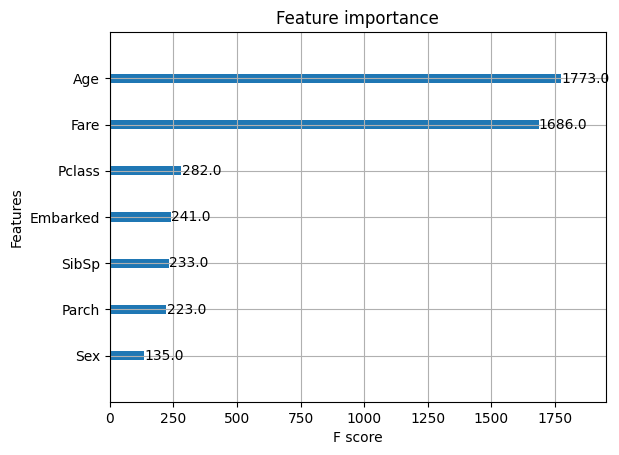

In [16]:
xgb.plot_importance(m2)

## Prediction

### Test DF predictions

In [17]:
dftest = pd.read_csv('/kaggle/input/titanic/test.csv')
xtest=dftest.drop(['Name','Ticket','Cabin','PassengerId'],axis=1)

In [18]:
xtest['Embarked'] = xtest['Embarked'].fillna('S')
xtest['Age'] = xtest['Age'].fillna(round(xtest.Age.mean()))
xtest['Sex'] = xtest['Sex'].replace({'male': 0, 'female': 1})
xtest['Embarked'] = xtest['Embarked'].replace({'S': 0, 'C': 1,'Q': 2})
xtest['Fare'] = xtest['Fare'].fillna(xtest.Fare.median())

/tmp/ipykernel_18/392077192.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  xtest['Sex'] = xtest['Sex'].replace({'male': 0, 'female': 1})
/tmp/ipykernel_18/392077192.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  xtest['Embarked'] = xtest['Embarked'].replace({'S': 0, 'C': 1,'Q': 2})


In [19]:
dftest['Survived'] = model.predict(xtest)

In [20]:
dfexport = dftest[['PassengerId','Survived']]
dfexport.to_csv('predictionoutput5.csv')